# DATASET

#### Source : https://www.kaggle.com/chicago/chicago-food-inspections

This information is derived from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. Inspections are performed by staff from the Chicago Department of Public Health’s Food Protection Program using a standardized procedure. The results of the inspection are inputted into a database, then reviewed and approved by a State of Illinois Licensed Environmental Health Practitioner (LEHP)

## Initialization

In [1]:
# Import findspark to read SPARK_HOME and HADOOP_HOME

import findspark
findspark.init()

In [2]:
# Import required library

from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .getOrCreate()

In [3]:
# Print Spark object ID
print(spark)

## Loading Data & Pre Processing

In [4]:
# Import Dataset Business Licenses & Owners
data = spark.read.csv("food-inspections.csv", header=True, inferSchema=True)

In [5]:
data.count()

183905

In [6]:
#Drop missing value
df = data.dropna()

In [7]:
df.count()

133057

In [8]:
from pyspark.sql.types import DoubleType

#Convert column `Latitude` and `Longitude` data type to float
df = df.withColumn("Latitude", df["Latitude"].cast("float"))
df = df.withColumn("Longitude", df["Longitude"].cast("float"))

In [9]:
df.printSchema()

root
 |-- Inspection ID: integer (nullable = true)
 |-- DBA Name: string (nullable = true)
 |-- AKA Name: string (nullable = true)
 |-- License #: integer (nullable = true)
 |-- Facility Type: string (nullable = true)
 |-- Risk: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zip: integer (nullable = true)
 |-- Inspection Date: timestamp (nullable = true)
 |-- Inspection Type: string (nullable = true)
 |-- Results: string (nullable = true)
 |-- Violations: string (nullable = true)
 |-- Latitude: float (nullable = true)
 |-- Longitude: float (nullable = true)
 |-- Location: string (nullable = true)



In [10]:
# Register the DataFrame as a SQL temporary view
df.createOrReplaceTempView("inspect")

## Data Query

In [11]:
#Location of Business along with it's food risk and inspection result
query = spark.sql("SELECT DISTINCT Latitude, Longitude, Risk, Results FROM inspect")

query.show()

+---------+----------+---------------+------------------+
| Latitude| Longitude|           Risk|           Results|
+---------+----------+---------------+------------------+
|41.692104| -87.65434|  Risk 1 (High)|              Pass|
| 41.90856|-87.646454|  Risk 1 (High)|Pass w/ Conditions|
|   41.986| -87.78753|  Risk 1 (High)|Pass w/ Conditions|
|41.909847| -87.73744|  Risk 1 (High)|Pass w/ Conditions|
|  41.9655| -87.65825|Risk 2 (Medium)|              Fail|
| 41.89668|  -87.7725|  Risk 1 (High)|Pass w/ Conditions|
| 41.96556| -87.65326|  Risk 1 (High)|Pass w/ Conditions|
|41.751846| -87.58615|  Risk 1 (High)|Pass w/ Conditions|
| 41.70404| -87.56588|  Risk 1 (High)|Pass w/ Conditions|
|41.944996| -87.64927|  Risk 1 (High)|Pass w/ Conditions|
|41.878048| -87.64774|  Risk 1 (High)|Pass w/ Conditions|
|41.890137| -87.63065|Risk 2 (Medium)|Pass w/ Conditions|
|41.757504| -87.56528|  Risk 1 (High)|              Fail|
|41.819443|-87.665375|   Risk 3 (Low)|              Fail|
|41.961594| -8

## Clustering Process

In [12]:
from pyspark.ml.feature import VectorAssembler

#Features assembler
vecAssembler = VectorAssembler(inputCols=["Latitude", "Longitude"], outputCol="features")
dfassembled = vecAssembler.transform(query)

In [13]:
dfassembled.show()

+---------+----------+---------------+------------------+--------------------+
| Latitude| Longitude|           Risk|           Results|            features|
+---------+----------+---------------+------------------+--------------------+
|41.692104| -87.65434|  Risk 1 (High)|              Pass|[41.6921043395996...|
| 41.90856|-87.646454|  Risk 1 (High)|Pass w/ Conditions|[41.9085617065429...|
|   41.986| -87.78753|  Risk 1 (High)|Pass w/ Conditions|[41.9860000610351...|
|41.909847| -87.73744|  Risk 1 (High)|Pass w/ Conditions|[41.9098472595214...|
|  41.9655| -87.65825|Risk 2 (Medium)|              Fail|[41.9654998779296...|
| 41.89668|  -87.7725|  Risk 1 (High)|Pass w/ Conditions|[41.8966789245605...|
| 41.96556| -87.65326|  Risk 1 (High)|Pass w/ Conditions|[41.9655609130859...|
|41.751846| -87.58615|  Risk 1 (High)|Pass w/ Conditions|[41.7518463134765...|
| 41.70404| -87.56588|  Risk 1 (High)|Pass w/ Conditions|[41.7040405273437...|
|41.944996| -87.64927|  Risk 1 (High)|Pass w/ Condit

In [14]:
from pyspark.ml.clustering import KMeans

#Training model
kmeans = KMeans().setK(5).setSeed(1)
model = kmeans.fit(dfassembled)

In [15]:
#Prediction with previous model
predictions = model.transform(dfassembled)
predictions.show(20)

+---------+----------+---------------+------------------+--------------------+----------+
| Latitude| Longitude|           Risk|           Results|            features|prediction|
+---------+----------+---------------+------------------+--------------------+----------+
|41.692104| -87.65434|  Risk 1 (High)|              Pass|[41.6921043395996...|         0|
| 41.90856|-87.646454|  Risk 1 (High)|Pass w/ Conditions|[41.9085617065429...|         3|
|   41.986| -87.78753|  Risk 1 (High)|Pass w/ Conditions|[41.9860000610351...|         1|
|41.909847| -87.73744|  Risk 1 (High)|Pass w/ Conditions|[41.9098472595214...|         1|
|  41.9655| -87.65825|Risk 2 (Medium)|              Fail|[41.9654998779296...|         2|
| 41.89668|  -87.7725|  Risk 1 (High)|Pass w/ Conditions|[41.8966789245605...|         1|
| 41.96556| -87.65326|  Risk 1 (High)|Pass w/ Conditions|[41.9655609130859...|         2|
|41.751846| -87.58615|  Risk 1 (High)|Pass w/ Conditions|[41.7518463134765...|         0|
| 41.70404

In [16]:
from pyspark.ml.evaluation import ClusteringEvaluator

#Evaluate clustering by computing silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.5968021262854156


In [17]:
#Centroids
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 41.7440957  -87.61554566]
[ 41.93161719 -87.75760653]
[ 41.96400966 -87.67770146]
[ 41.88640256 -87.6475393 ]
[ 41.80659864 -87.70610671]


In [18]:
# Visualization using pixiedust
import pixiedust

Pixiedust database opened successfully



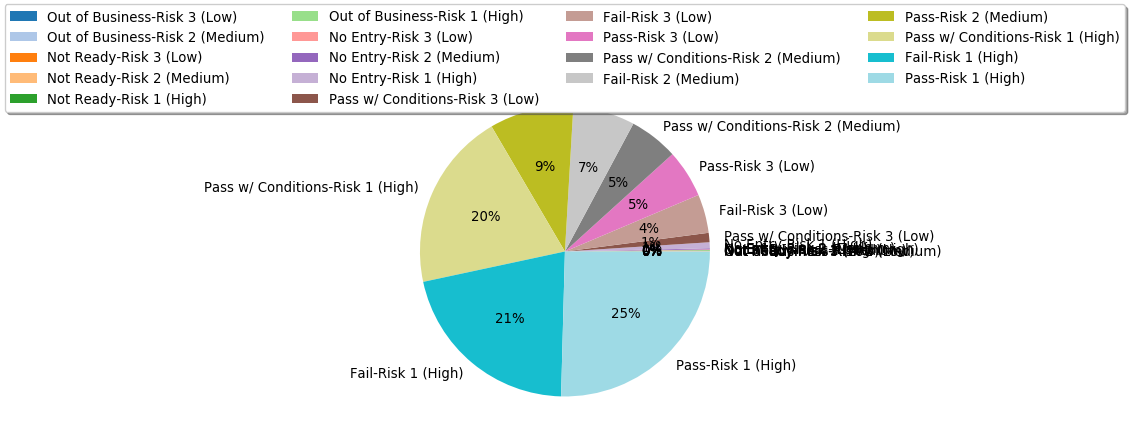

In [19]:
display(predictions)

## Visualisasi